# Table of Contents
2. [Contexte](#context)
3. [Récupération des données](#recupdonnee)
4. [Nettoyage \& Transformation](#titre3)
5. [Apprentissage non supervisée](#titre4)
6. [Apprentissage supervisée](#titre5)
7. [Construction de l'API](#titre6)

# Contexte <a name="context"></a>

StackOverflow une plateforme mondialement reconnue dans le monde de l'informatique, permet d'aider les débutants ainsi que les pros dans plusieurs domaines/technologies en lien direct ou indirect avec l'informatique. Cette plateforme permet de promouvoir l'entraide au sein de sa communauté, car tout le monde peut poser sa question sur son site, et toute personne peut répondre à une question si celle-ci pense avoir la bonne réponse.

Victime de son succés le nombre de question ne cesse d'augmenter sur la plateforme et de s'étendre sur de nouveaux domaines/technologies informatique. Pour avoir un bon retour et une bonne réponse sur une question, StockOverFlow ont mis en place un système de tag qui permet a l'utilisateur de classifier le contexte de sa question. D'un autre côté, ils ont réussi à cibler au sein de leur commnunauté des experts de chaque tag. L'idée est donc à chaque fois qu'il y a une nouvelle question, de notifier aux experts des tags de la question pour assurer a l'utilisateur la meilleure des réponses. L'identification du bon tag pour la question devient donc crucial, surtout pour les débutants qui arrivent tout juste dans le monde informatique et qui doivent bien cibler son auditoire et bien exprimer sa question.

Nous allons voir dans ce rapport les étapes clés mise en place pour arriver à prédire des tags à partir du titre et du corps de la question.

# Récupération des données <a name="recupdonnee"></a>

Les données StackOverFlow sont stockées dans une base de données en ligne, cette base de données contient non seulement les posts des gens mais pleins d'autres tables de références. La table principale à utiliser est la table post, une petite analayse nous permet de découvrir que cette table contient non seulement les questions des utilisateurs mais aussi les réponses par rapport a chaque question et plein d'autres informations complémentaires tel que le score, le nombre de réponse reçus (si c'est une question) ...

Nous savons dorénavant la table à interoger pour récupérer nos donnée et le filtre à appliquer (PostTypeId = 1) pour récupérer toutes nos questions. Lors de l'execution des requêtes nous remarquons que la plateforme ne permet pas d'extraire plus de 50 000 entrée. Nous sommes donc obligés de trouver un moyen d'extraire les données par petits lots et de s'assurer que la donnée n'est pas récupérée deux fois. Nous construisons une requête avec la fonction analytique dense_rank qui permet de redonner un identifiant a chaque ligne basé sur des critères fourni. Ainsi le critère qu'on a choisi pour s'assurer que l'identifiant soit le même à chaque exécution est l'identifiant par ordre croissant. Plus explicitement l'identifiant le plus petit qui répond à notre critère aura un rang égal à 1 et ainsi de suite. Entre deux executions nous pouvons donc choisir le nombre de ligne à extraire en passant sur des tranches de rang différentes.

L'extraction étant manuelle et comme elle est gourmante en temps, on a fait le choix pour l'instant d'extraire que les 1 millions premières lignes de la base de données. Nous estimons que le nombre est récupéré est largement suffisant pour commencer notre deuxième étape et entrainer à la fin notre modèle.

# Nettoyage & Transformation <a name="titre3"></a>

Notre première étape de nettoyage consiste à se débarasser des colonnes qui ne vont pas être utile dans notre analyse, notamment les date de création, dernière modification, clôture ...

Notre deuxième étape consiste à transformer les tags originellement renseigné en balise en les transformants en tableau cela nous permettra par la suite d'effectur des analyses sur les tags les plus utilisés ainsi que le nombre de tag utilisé par question. Nous remarquons que le tags le plus utilisé est de loin le C# suivi par le java, php et .net. Le nombre de tags décroit exponentiellement. Notre but et objectif final reste de créer un moteur qui permet de proposer/aider l'utilisateur à déduire le tag associé à sa question, pour cela nous n'avons pas besoin de tous les tags et allons nous focaliser seulement à prédire les 100 tags les plus utilisés. 

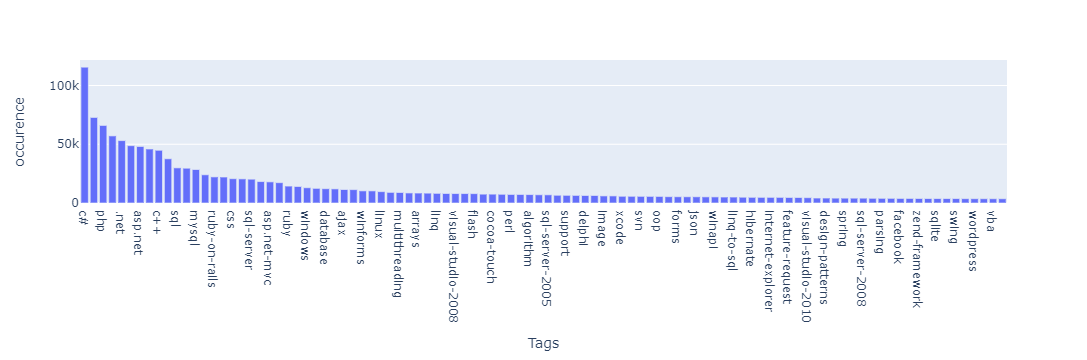

In [16]:
res = Counter(map(str.strip, chain.from_iterable(df["Tags"].fillna('Inconnu').str.split(' '))))
dfTags = pd.DataFrame.from_dict(res, orient='index').reset_index()
dfTags = dfTags.rename(columns={'index':'Tags', 0:'occurence'})
dfTags = dfTags.sort_values("occurence",ascending=False)
fig = px.bar(dfTags.nlargest(100,"occurence"),x="Tags", y = 'occurence')
fig.show()

Notre première transformation de la donnée consiste à enlever des questions tous les tags qui ne sont pas présent dans la liste des 100 tags et par la suite enlever les questions n'ayant plus de tags. 

Dans les données récupérées nous avons aussi l'information de si une question a eu une réponse ou pas. Nous faisons donc la supposition qu'une question n'ayant pas eu de réponse est une question qui est soit mal posée soit que les tags associés à cette question n'était pas pertinent. De ce fait nous décidons d'enelever de notre dataframe toutes les questions n'ayant pas eu de réponse.

Avec toutes ces transformation et réduction du scope nous nous retrouvons toujorus avec un dataframe très volumineux pour le pc avec lequel on souhaite effectuer l'apprentissage et la prédiction. Nous décidons de réduire un peu plus en gardant seulement 100 000 observations. Pour cela il faut choisir les meilleurs questions à garder pour faire notre apprentissage. Nous optons d'utiliser l'indicateur du score qui représente le nombre de personne ayant liké la question moins le nombre de personne n'ayant pas aimé la question. Plus la question a un score elevé plus la question est pertinente car beaucoup plus que la majorité ont voté positivement pour cette question. Notre dataframe final contient les 100 000 questions ayant les scores les plus elevés.

### Transformation textuelle

Nous avons dorénavant un dataframe avec 3 colonnes principales : Le titre de la question, le corps de la question et les tags associés à la question. Nos transformations textuelles vont s'opérer sur le titre et le coprs de la question. On remarque rapidement que le corps contient des balises html. Notre première transformation consitera à extraire le texte inclut dans les balises html et enlever toute information lié au formatage de la donnée en html. 

Pour extraire les données des balises html nous utilisons la librairie BeautifulSoup la fonction get_text() permet d'extraire facilement et simplement le contenu d'un texte en format html. Une fois les données des balises html extraites on se retrouve avec deux textes pour lesquels on peut appliquer dorénavant les mêmes fonctions de transformations.

Pour pouvoir faire de l'apprentissage efficacement il faut réussir à eliminer de notre texte tous les mots qui ne donne aucune information sur le sujet de la question. Ces mots sont souvent des mots de coordination pour pouvoir lier deux phrases ou deux idées ensemble et qui n'a lieu d'être que pour rendre la phrase bien construite grammaticalement parlant. Une autre transformation qu'on applique sur notre donnée est de récupérer la racine grammatical des mots, cela permettra au moteur de pouvoir reconnaitre les questions ayant utilsé plusieurs versions dérivées du mot mais qui ont la même racine. 

Nos étapes de transformation textuelles se résument dans les étapes suivantes :
- Ne garder des questions que les lettres et chiffres avec les charactères suivants : ".#+-"
- Mettre tous les mots en minuscules
- Lemmatization des mots pour découvrir la racine de chaque mot
- Enlever les stopwords incrémenter d'une liste personnalisée qui inclut : error, warning, please, help, can

StackOverFlow étant une plateforme utilisée pour des questions en relation avec l'informatique, quasi toutes les questions sont relatives à une erreur qu'une personne a rencontré. De même que les warnings sont quasi présent dans tous les langages. Ces mots non considérés comme des stopwords nativement on les rajoute manuellement pour mieux correspondre à notre problématique de prédiction de tags sur des sujets informatiques. 

Une étape supplémentaire a été rajoutée dans notre transformation textuelle qui consiste essentiellement à créer des bigram. La librairie bigram de gensim permet d'analyser l'occurence des mots qui apparaissent souvent ensemble et de les transformer en un seul mot. Cela est très pertinent pour ne garder qu'un seul mot au lieu de deux. Un exemple d'utulisation est visual studio. Nous allons rarement rencontré visual sans studio il est donc logique de les assembler et ne les considérer comme un seul mot. Cela évite d'en considérer chacun tout seul vu que les deux n'ont de sens qu'une fois ensemble.

# Apprentissage non supervisé <a name="titre4"></a>

L'apprentissage non supervisé consiste à prédire des tags seulement en utilisant du texte brut. La méthode la plus connue qui permet de faire cela est la méthode LDA (Latent Ditrichlet Allocation). Cette méthode permet d'extraire les sujets les plus dominants dans tous les documents et pour chaque sujet affecter une liste de mot qui permet de décrire le sujet. Le nombre de sujet est donné en paramétre du model et le model essaie de calculer la probabilité que chaque mot appartiennent à un sujet donné.  

L'exercice de retrouver quels tags est associé à chaque sujet est assez gourmand, nous faisons donc le choix de déterminer d'abord les 20 sujets les plus dominants. 

In [66]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.295*"list" + 0.154*"item" + 0.075*"word" + 0.066*"tool" + 0.049*"match" + '
  '0.027*"contain" + 0.026*"assume" + 0.026*"prevent" + 0.023*"regex" + '
  '0.014*"regular_expression"'),
 (1,
  '0.251*"java" + 0.229*"array" + 0.098*".." + 0.067*"loop" + 0.052*"json" + '
  '0.038*"appears" + 0.018*"hello_world" + 0.003*"-a" + 0.000*"library" + '
  '0.000*"lib"'),
 (2,
  '0.170*"int" + 0.110*"+" + 0.058*"n" + 0.053*"xml" + 0.044*"button" + '
  '0.037*"long" + 0.033*"integer" + 0.031*"parent" + 0.031*"layout" + '
  '0.027*"either"'),
 (3,
  '0.119*"approach" + 0.111*"top" + 0.104*"buffer" + 0.079*"practice" + '
  '0.045*"scenario" + 0.042*"func" + 0.039*"technique" + 0.032*"along" + '
  '0.016*"optimization" + 0.009*"rollback"'),
 (4,
  '0.263*"http" + 0.153*"size" + 0.118*"url" + 0.105*"request" + 0.057*"api" + '
  '0.035*"length" + 0.030*"ajax" + 0.021*"split" + 0.008*"maximum" + '
  '0.008*"specification"'),
 (5,
  '0.151*"question" + 0.067*"answer" + 0.057*"post" + 0.047*"link" 

Nous remarquons que les mots qui ressortent dans chaque sujet sont des mots en relation avec la programmation et qu'il est difficile de déterminer à partir de ceux la le programme associé. Si je prends l'exemple des 3 premiers sujets on voit que les 3 sujets peuvent appartenir a n'importe quel langage de programmation tel que le C, java, python ou du shell. Les 3 sujets contient une concatenation des mots utilisés dans plusieurs langages de programmation. La ou le sujet 5 est en relation étroite avec des langages qui touchent a des plateformes web, tel que le html, les API et le javascript. 

Malgré le fait que les sujets ne sont pas bien défini nous avons essayé de travailler avec cette catégorisation et on a extrait de chaque question le thème le plus dominant. Nous remarquons que la distribution des réponses est concentré sur un seul thème à plus de 90%.

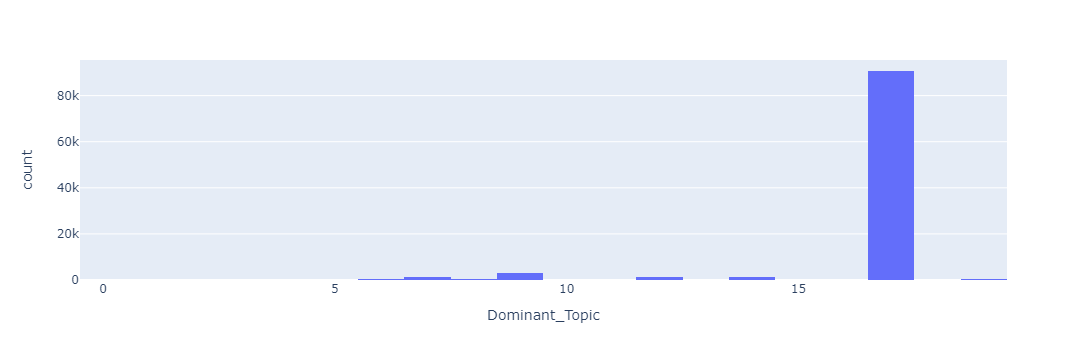

In [72]:
px.histogram(df_topic_sents_keywords,x='Dominant_Topic')

Malheureusement la méthode d'apprentissage non supervisé ne permet pas d'identifier nos sujets avec précisions et cela vient aussi du fait que les langages de programmation sont très simmilaires même en lisant du code il est rarement difficile de dissocier les termes d'un langage à un autre. Les syntaxes de programmation sont très semblables. Nous ne pourrons pas atteindre à des résultats plus performants que d'utiliser des méthodes d'apprentissage supervisé. 

# Apprentissage supervisé <a name="titre5"></a>

L'aprentissage supervisé consiste à utiliser l'information des tags réels pour calibrer notre modèle et pouvoir prédire pqr la suite les tags associés à des observations dont la classification n'est pas connue. Notre démarche d'apprentissage supervisé consiste dans les étapes suivantes : 
- Transformation du champ tag en plusieurs colonnes binaires
- Vectorisation du texte (Titre + corps de la question)
- Séparation du dataset en deux dataset training et test
- Définition de notre indicateur de comparaison des modèles
- Test et comparaison de plusieurs modèle d'apprentissage (LinearSVC, Passive Agressive Classifier, Logistic regression) 

Pour la transformation des valeurs de tags en colonne nous avons utilisé la librairie MultiLabelBinarizer. Cette librairie permet facilement de transformer les tags en un tableau binaire et inversement. La fonction d'inversement sera pratique quand on arrivera à prédire nos tags et pour pouvoir retrouver le nom derrière chaque tag prédit.

La vectorisation se fait quant à elle grâce à la méthode TF-IDF. Cette méthode permet de calculer la pertinence d'un mot dans un document par rapport au reste des documents. Cet indicateur est corrélé positivement à la fréquence du mot dans le document et négativement par rapport a la fréquence du mot dans les autres documents (d'où le I du Inverse Document Frequency). Plus exactement cet indicateur est égale à la frequence ud mot dans le document multiplié par l'inverse de la proportion de document ayant le mot à l'échelle logarithmique. Ainsi les articles le/la dans la langue française bien que trop présent dans un texte francais mais comme présent partout son IDF sera égale à 0, en effet les aticles de la langue française n'apporte aucune information complémentaire. 

Pour la séparation du dataset on utilise les foncitons train_test_split de scikit learn en gardant 20% de notre dataset pour les tests des modèles.

Nos questions peuvent avoir plusieurs tags, il s'agit donc là d'un problème de classification multiple. Pour pouvoir juger de la pertinence d'un modèle nous allons utiliser l'indicateur de similarité de Jacard qui représente la proportion de l'intersection de deux ensembles par rapport à l'union des deux ensembles. Dans notre cas cela représente le nombre de cas positif commun divisé par le nombre de positifs dans un des deux ensembles. Plus l'indicateur est proche de 1 plus l'intersection est égale a l'union et par conséquent plus les deux ensembles sont similaires.

Les modèles de classification que nous allons essayer de comparer sont les suivants :
- Linear SVC (support vector classification) 
- Passive Agressive Classifier 
- Logistic Regression 

Le point commun de ces 3 modèles est qu'ils sont plus utilisés pour résoudre des problèmes binaires. Cependant dans notre cas de figure on a un problème qui est de type multi-label. Pour cela nous allons utiliser en plus le modèle One Vs Rest qui permet de diviser notre problème multi label en plusieurs problèmes binaires. Les problèmes binaires sont alors 1 class contre tous le reste, autrement dit notre observation appartient elle à la classe qu'on essaie de résoudre ou au reste. 

Le modèle le plus performant qu'on a pu tester est finalement le modèle utilisant la régression logistique. Avec ce modèle nous avons aussi essayer d'afficher les mots qui caractérisent le plus chaque tag. Le résultat semble assez cohérent. Ci-dessous un petit extrait de quelques tags.

apache: access usr request 2009 excel host allow rule dependency apache </br>
bash: exist e.g real well look done script shell echo bash</br>
c: language written building implementing pointer char struct define gcc printf</br>
c#: bool var generic new delegate .net linq foreach console.writeline c#</br>
c++: connect container member const vector template virtual boost std c++</br>

# Construction de l'API <a name="titre6"></a>

Maintenant que nous avons un modèle fonctionnel nous pouvons nous attaquer à la création de notre API. Notre API consiste à prendre en entrée un titre et un body (en version html ou pas) et de produire en sortie une réponse sur les tags associés à la question posée.

Pour cela nous avons crée une classe TagPrediction qui contient toutes les fonctions utiles pour la prédiction. Cette classe permet d'initialiser l'objet en important tous les objets nécessaires à notre modélisation. Dans les objets on a le modèle bigram qui permet de reproduire les couples de mots qui ont un sens à être assemblé, le multilabel qui permet de retrouver le nom des tags à partir de la séquence binaire de notre prédiction, le vectorizer qui permet de reconstruire notre algorithme TF-IDF et enfin notre modèle OneVsRest qui permet de prédire le tag sur la donnée pré-traitée. 

Notre prédiction suit et reproduit exactement les mêmes étapes énoncées dans notre analyse. Par dessus cette prédiction nous avons créé une interface assez simple qui permet à l'utilisateur de remplir un formulaire avec un titre et un body et de soumettre à la prédiction. Le résultat est renvoyé sur un page html qui permet d'afficher un récapitulatif de ce qui a été demandé notamment le titre la question et les tags prédits.